## Calculate the 1-D decorrelation scale for the CA ROMS ##

Decorrelation scale is calculated by calculating an autocorrelation function:

AutoCorrelation:


$$ r_k = \frac{ \sum_{i=1}^{N-k}(Y_i - \bar Y)(Y_{i+k} - \bar Y} {\sum_{i=1}^N (Y_i - \bar Y)^2} $$


where $r_k$ is the autocorrelation at a lag of $k$.

Notes:
Using the z-depth level roms. Choosing z=9  
Based on profiling, getting data in chunks of 2500 was the limit and took about 25 Seconds from home for a single point.  





Options:   
`import statsmodels.api as sm`  
`sm.tsa.acf(x)`  

Pandas:  
`series.autocorr()`


In [1]:
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import datetime as dt
import time
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats
from tqdm import tqdm
import seaborn as sns
import vincenty
from scipy.ndimage.filters import gaussian_filter

In [2]:
def make_map(projection=ccrs.PlateCarree(), extent=(-130.5,-116.75,32,42)):
    """ Map plotting helper function """
    fig, ax = plt.subplots(subplot_kw={'projection': projection})
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    gl = ax.gridlines(draw_labels=True,)
    gl.xlines = False
    gl.ylines = False
    gl.xlabels_top = False
    gl.ylabels_right = False
    coast_10m = cfeature.NaturalEarthFeature("physical", "land", "10m", edgecolor="k", facecolor="0.8")
    ax.add_feature(coast_10m)    
    return fig, ax

__Preproccess Roms Data to lower data request size__

In [12]:
# url = 'https://oceanmodeling.ucsc.edu:8443/thredds/dodsC/ccsra_2016a_phys_agg_zlevs/fmrc/CCSRA_2016a_Phys_ROMS_z-level_(depth)_Aggregation_best.ncd' # vertically gridded
url = "https://oceanmodeling.ucsc.edu:8443/thredds/dodsC/ccsra_2016a_phys_agg_slevs/fmrc/CCSRA_2016a_Phys_ROMS_Sigma-level_Aggregation_best.ncd"

# Re-grid the data, there is a slight error associated with this. See 'ungrid' plot
roms_ds = xr.open_dataset(url)
roms_temp = roms_ds['temp']
roms_temp_latitude = roms_temp['lat_rho'].values[:,0]
roms_temp_longitude = roms_temp['lon_rho'].values[0,:]
roms_temp = roms_temp.assign_coords({"eta_rho":roms_temp_latitude, "xi_rho":roms_temp_longitude})
roms_temp = roms_temp.rename({"eta_rho":"latitude", "xi_rho":"longitude"})
roms_temp = roms_temp.drop('lat_rho', errors='ignore')
roms_temp = roms_temp.drop('lon_rho', errors='ignore')
roms_temp = roms_temp.drop('time_run', errors='ignore')
roms_temp = roms_temp.isel(s_rho=-1)

In [4]:
roms_temp

<xarray.DataArray 'temp' (time: 4224, s_rho: 42, latitude: 181, longitude: 186)>
[5972617728 values with dtype=float64]
Coordinates:
  * s_rho      (s_rho) float64 -0.9881 -0.9643 -0.9405 ... -0.03571 -0.0119
  * time       (time) datetime64[ns] 2011-01-02 2011-01-03 ... 2022-07-26
  * latitude   (latitude) float64 30.0 30.1 30.2 30.3 ... 47.7 47.8 47.9 48.0
  * longitude  (longitude) float64 -134.0 -133.9 -133.8 ... -115.7 -115.6 -115.5
Attributes:
    units:      Celsius
    long_name:  potential temperature
    time:       ocean_time
    field:      temperature, scalar, series

/Users/patrick/opt/anaconda3/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/patrick/opt/anaconda3/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


NameError: name 'distances' is not defined

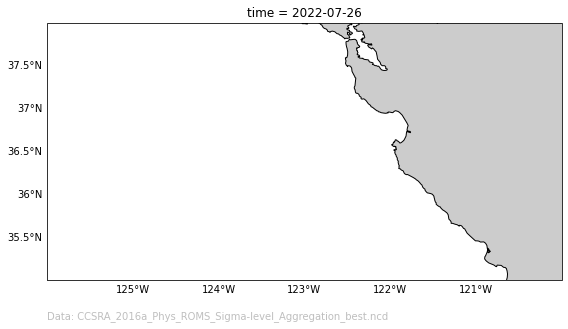

In [5]:
fig, ax = make_map(extent=(-126,-120,35,38))
fig.set_size_inches(8,6)
roms_temp.isel(time=-1).plot(ax=ax,)
ax.text(x=0,y=-.15,s="Data: {}".format(url.split("/")[-1]),transform=ax.transAxes,size=10,color=".75")
plt.tight_layout()
# ax.scatter(-122.5,36.8,color='r')

for i in range(30):
    # lat_ix = np.where(roms_temp_latitude == 36.8)[0]
    # lon_ix = np.where(roms_temp_longitude == -121.9)[0]
    # ax.scatter(roms_temp_longitude[lon_ix-i],roms_temp_latitude[lat_ix],color='k',zorder=10)

    lat_ix = np.where(roms_temp_latitude == 36.8)[0]
    lon_ix = np.where(roms_temp_longitude == -122)[0]
    j = i//2
    cax = ax.scatter(roms_temp_longitude[lon_ix-i],roms_temp_latitude[lat_ix-(j)],c=distances[i],zorder=11,vmin=0,vmax=350)
    # print(i, i - i%2)
    
    
    # print(roms_temp_longitude[lon_ix-i],roms_temp_latitude[lat_ix])
plt.colorbar(cax,label='Distance [km]',shrink=0.5)
# plt.savefig("../figures/CAROMS_map_trans.png", dpi=300,bbox_inches='tight',transparent=False)

NameError: name 'lons' is not defined

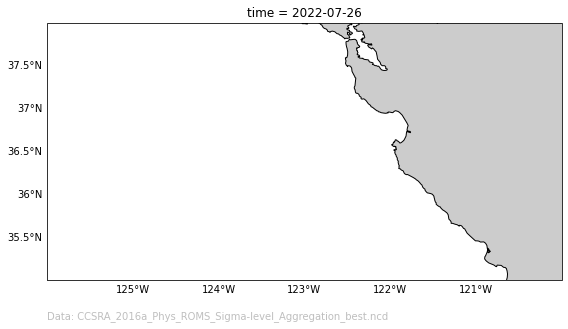

In [6]:
fig, ax = make_map(extent=(-126,-120,35,38))
fig.set_size_inches(8,6)
roms_temp.isel(time=-1).plot(ax=ax,)
ax.text(x=0,y=-.15,s="Data: {}".format(url.split("/")[-1]),transform=ax.transAxes,size=10,color=".75")
plt.tight_layout()
ax.scatter(lons,lats)

__Get 1-D Data from a single Point__

In [23]:
%%time
def get_data_chunks(ds, n_chunks=4):
    """ Download data in chunks from remote thredds server to avoid limits on request sizes """
    stack_size = ds.shape[0]
    chunk_size = int(stack_size / n_chunks)
    
    for i in range(n_chunks):
        if i == 0:
            df = ds.isel(time=slice(0,chunk_size)).load().to_pandas().to_frame()
        
        else:
            t_df = ds.isel(time=slice(chunk_size*i,chunk_size * (i+1))).load().to_pandas().to_frame()
            df = pd.concat((df, t_df))
    
    return df.rename(columns={0:'temp'})

def remove_season(df):
    """ Remove the seasonality of data """
    df['doy'] = df.index.day_of_year
    clim = df.groupby('doy')['temp'].mean()
    df['clim'] = [ clim.loc[x] for x in df['doy'] ]
    df['index'] = df['temp'] - df['clim']
    return df


def calculat_e_scale(series):
    e_length = 1/np.e
    return sm.tsa.acf(series, nlags=365, adjusted=False)
    # e_scale = np.argmin(np.abs(auto_fxn_adj - e_length)) # find where the smallest value (ie closest to e_length)
    # return auto_fxn_adj

def auto_corr_plots(df, i, lat, lon):
    e_length = 1/np.e
    # e_scale = calculat_e_scale(df['index'])

    fig, ax = plt.subplots()
    fig.set_size_inches(12,6)
    sm.graphics.tsa.plot_acf(df['index'].values.squeeze(), lags=365, ax=ax);
    auto_fxn_adj = sm.tsa.acf(df['index'], nlags=365, adjusted=False)

    ax.plot(np.arange(0,366),auto_fxn_adj)

    ax.hlines(y=e_length,xmin=-1,xmax=365,color='k',zorder=100)

    ax.set_xlim(-2,365)
    ax.set_ylim(-.3,1.1)
    ax.set_title('Autocorrelation:Seaonality Removed, 4DVAR ROMS\n sigma=32 [{} N,{} W]'.format(lat,lon))
    plt.savefig("../figures/decorr/auto_corr_deseasonal_{}.png".format(str(i).zfill(2)), dpi=300,bbox_inches='tight',transparent=False)
    plt.close()




CPU times: user 11 µs, sys: 1 µs, total: 12 µs
Wall time: 15.7 µs
Compiler : 321 ms


In [25]:
i = 1
str(i).zfill(2)

'01'

## Calculate Decorrelation scale for an offshore transect ##

In [26]:
%%time
lat_ix = np.where(roms_temp_latitude == 36.8)[0]
lon_ix = np.where(roms_temp_longitude == -122)[0]
lats = []
lons = []
auto_corr = np.zeros(shape=(30,366))


for i in tqdm(range(30)):
    j = i//2
    llon = roms_temp_longitude[lon_ix-i][0]
    llat = roms_temp_latitude[lat_ix-(j)][0]
    df = get_data_chunks(roms_temp.sel(latitude=llat, longitude=llon), n_chunks=5)
    df = remove_season(df)
    auto_corr[i,:] = calculat_e_scale(df['index'])
    auto_corr_plots(df, i, llat,llon)
    lats.append(llat)
    lons.append(llon)

  0%|                                                    | 0/30 [00:00<?, ?it/s]/Users/patrick/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(
/Users/patrick/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(
  3%|█▍                                          | 1/30 [00:58<28:16, 58.51s/it]/Users/patrick/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(
/Users/patrick/opt/anaconda3/lib/python3.9/site-packag

CPU times: user 27.8 s, sys: 1.64 s, total: 29.5 s
Wall time: 25min 58s


In [27]:
distances = []
for i in tqdm(range(30)):
    j = i//2
    llon = roms_temp_longitude[lon_ix-i][0]
    llat = roms_temp_latitude[lat_ix-(j)][0]
    distances.append(round(vincenty.vincenty((llon,llat), (roms_temp_longitude[lon_ix],roms_temp_latitude[lat_ix][0])),2))
distances

100%|████████████████████████████████████████| 30/30 [00:00<00:00, 20947.08it/s]


[0.0,
 11.14,
 23.05,
 33.94,
 46.11,
 56.95,
 69.18,
 79.99,
 92.25,
 103.05,
 115.33,
 126.13,
 138.42,
 149.21,
 161.52,
 172.31,
 184.62,
 195.41,
 207.74,
 218.52,
 230.86,
 241.63,
 253.98,
 264.76,
 277.12,
 287.89,
 300.26,
 311.03,
 323.41,
 334.18]

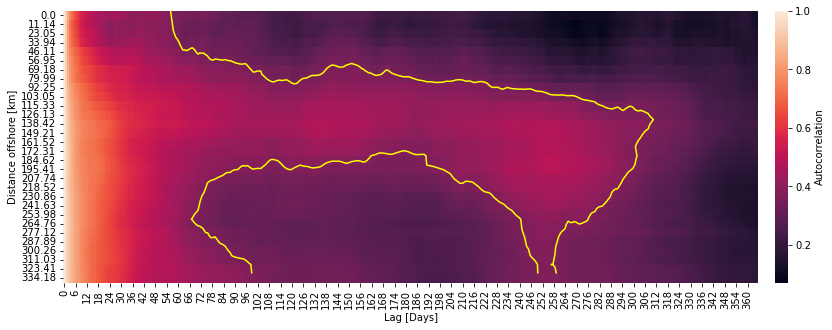

In [28]:
# fig, ax =plt.subplots()
# sns.heatmap(auto_corr,yticklabels=distances)

data = gaussian_filter(auto_corr, sigma=2)
e_length = 1/np.e
fig, ax = plt.subplots(figsize=(15, 5))
cax = sns.heatmap(data=auto_corr, cbar_kws={'pad': 0.02,'label':'Autocorrelation'}, ax=ax,yticklabels=distances)
# plt.colorbar(cax, label= "Autocorrelation")
ax.set_ylabel('Distance offshore [km]')
ax.set_xlabel('Lag [Days]')
ax.contour( auto_corr, colors='yellow',levels=[e_length])
# plt.savefig("../figures/CAROMS_decorrelation_heatmap_seasonal.png", dpi=300,bbox_inches='tight',transparent=False)


In [ ]:
sns.kdeplot(x=range(0,366),distances, data cmap="Reds", shade=True, bw_adjust=.5)
# plt.show()

/Users/patrick/opt/anaconda3/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/patrick/opt/anaconda3/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


NameError: name 'e_scales' is not defined

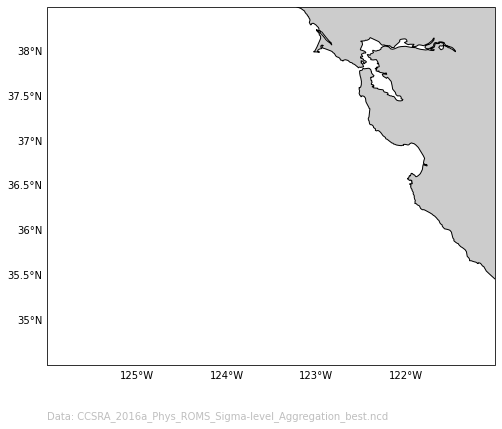

In [29]:
fig, ax = make_map(extent=(-126,-121,34.5,38.5))
fig.set_size_inches(8,6)
# roms_temp.isel(time=-1).plot(ax=ax,)
ax.text(x=0,y=-.15,s="Data: {}".format(url.split("/")[-1]),transform=ax.transAxes,size=10,color=".75")
plt.tight_layout()
cax = ax.scatter(lons,lats,c=e_scales,zorder=11)
plt.colorbar(cax, label='Decorrelation Scale [Days]')

# plt.savefig("../figures/CAROMS_map_decorrelation.png", dpi=300,bbox_inches='tight',transparent=False)

AutoCorrelation by Hand:


$$ r_k = \frac{ \sum_{i=1}^{N-k}(Y_i - \bar Y)(Y_{i+k} - \bar Y)} {\sum_{i=1}^N (Y_i - \bar Y)^2} $$


where $r_k$ is the autocorrelation at a lag of $k$.



In [ ]:
t = df['index']
t.plot()

In [ ]:
t = df['index']
acf_list = []
mu = t.mean()

for lag in range(0, 120):
    acf_list.append(np.sum((t - mu).iloc[lag:] * (t.shift(lag) - mu).iloc[lag:]) / np.sum((t - mu) ** 2))
np.array(acf_list)



fig,ax = plt.subplots()
ax.scatter(range(0,120),acf_list)

t = df['index']
acf_list = []
mu = t.mean()

for lag in range(0, 120):
    acf_list.append(np.sum((t - mu).iloc[lag:] * (t.shift(lag) - mu).iloc[lag:]) / np.sum((t - mu) ** 2))
np.array(acf_list)



In [ ]:
sm.tsa.acf(t, nlags=120).shape

## Make some plots ##

Text(0.5, 1.0, 'Autocorrelation w/ Seasonality 4DVAR ROMS\n sigma=32 [36.8,-122.5]')

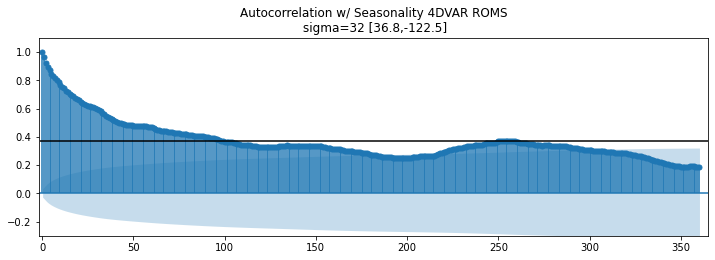

In [30]:
e_length = 1/np.e
# e_scale = calculat_e_scale(df['index'])

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['index'].values.squeeze(), lags=360, ax=ax1)
ax1.hlines(y=e_length,xmin=-1,xmax=365,color='k',zorder=100)
# ax1.vlines(x=e_scale,ymin=-1,ymax=1.2,color='k',zorder=100)
# ax1.text(x=.5,y=.9,s="e-scale: {} days".format(e_scale), transform=ax1.transAxes,size=20, ha='center',)


ax1.set_xlim(-2,365)
ax1.set_ylim(-.3,1.1)
ax1.set_title('Autocorrelation w/ Seasonality 4DVAR ROMS\n sigma=32 [36.8,-122.5]')

# plt.savefig( "../figures/auto_corr_seasonal.png", dpi=300,bbox_inches='tight',transparent=False)

/Users/patrick/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(
/Users/patrick/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


Text(0.5, 1.0, 'Autocorrelation:Seaonality Removed, 4DVAR ROMS\n sigma=32 [36.8,-122.5]')

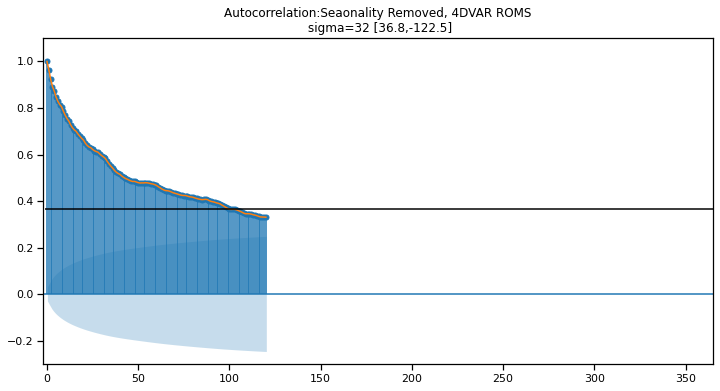

In [50]:
e_length = 1/np.e
e_scale = calculat_e_scale(df['index'])

fig, ax = plt.subplots()
fig.set_size_inches(12,6)
sm.graphics.tsa.plot_acf(df['index'].values.squeeze(), lags=120, ax=ax);
auto_fxn_adj = sm.tsa.acf(df['index'], nlags=120, adjusted=False)

ax.plot(np.arange(0,121),auto_fxn_adj)


ax.hlines(y=e_length,xmin=-1,xmax=365,color='k',zorder=100)
# ax.vlines(x=e_scale,ymin=-1,ymax=1.2,color='k',zorder=100)
# ax.text(x=.5,y=.9,s="e-scale: {} days".format(e_scale), transform=ax.transAxes,size=20, ha='center',)


ax.set_xlim(-2,365)
ax.set_ylim(-.3,1.1)
ax.set_title('Autocorrelation:Seaonality Removed, 4DVAR ROMS\n sigma=32 [36.8,-122.5]',)
# plt.savefig( "../figures/auto_corr_deseasonal.png", dpi=300,bbox_inches='tight',transparent=False)


<Figure size 432x288 with 0 Axes>

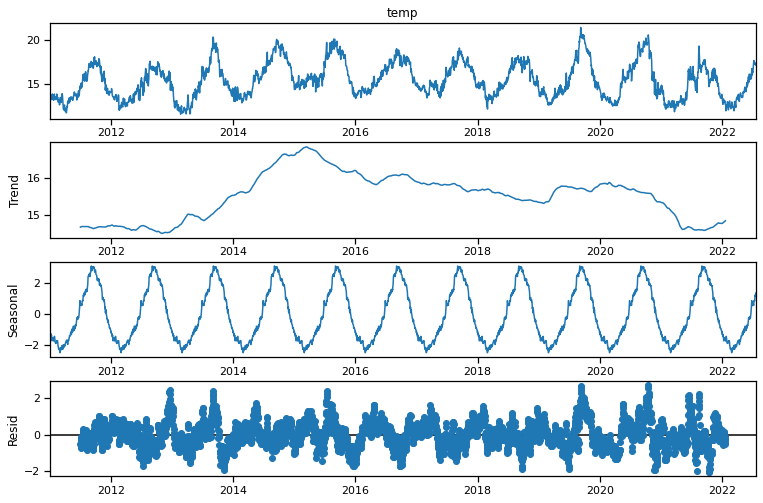

In [51]:
sns.set_context('notebook')
fig = plt.figure()
fig = sm.tsa.seasonal_decompose(df['temp'],model='additive',period=365,).plot(fig);
fig.set_size_inches(12,8)
plt.subplots_adjust(wspace=0, hspace=.25)
# plt.savefig( "../figures/seasonal_deocomposition.png", dpi=300,bbox_inches='tight',transparent=False)

In [53]:
llat, llon

(35.4, -124.9)

__ARMA Model Example__ - https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_arma_0.html 

In [ ]:


arma_mod20 = sm.tsa.statespace.SARIMAX(df.temp, order=(2,0,0), trend='c').fit(disp=False)
print(arma_mod20.params)
arma_mod30 = sm.tsa.statespace.SARIMAX(df.temp, order=(3,0,0), trend='c').fit(disp=False)
print(arma_mod20.aic, arma_mod20.bic, arma_mod20.hqic)


In [ ]:
print(sm.stats.durbin_watson(arma_mod30.resid))
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(111)
ax = plt.plot(arma_mod30.resid)

In [ ]:
resid = arma_mod30.resid

In [ ]:
stats.normaltest(resid)

In [ ]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(111)
fig = qqplot(resid, line='q', ax=ax, fit=True)

In [ ]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(resid, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(resid, lags=40, ax=ax2)

In [ ]:
r,q,p = sm.tsa.acf(resid, fft=True, qstat=True)
data = np.c_[r[1:], q, p]
index = pd.Index(range(1,q.shape[0]+1), name="lag")
table = pd.DataFrame(data, columns=["AC", "Q", "Prob(>Q)"], index=index)
print(table)

In [ ]:
predict_sunspots = arma_mod30.predict(start='2020', end='2024', dynamic=False)

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
df.temp.plot(ax=ax)
predict_sunspots.plot(ax=ax, style='r');

In [ ]:
def mean_forecast_err(y, yhat):
    return y.sub(yhat).mean()

mean_forecast_err(df.temp, predict_sunspots)

## Profiling the UCSC Thredds server ##

Basically, taking chunks of temperature records from a single depth around 2500 deep in time made the most sense

In [ ]:
times = []
size = list(range(0,1001,100))
for n in size:
    time.sleep(1)
    start = time.time()
    off_mbar = roms_temp.sel(latitude=36.8, longitude=-122.5).isel(time=slice(0,n)).load()
    end = time.time()
    times.append(end - start)
    print("Slice Size: {} | Seconds: {}".format(n,end - start))



In [ ]:
fig,ax = plt.subplots()
ax.plot(size,times)